In [22]:
import pandas as pd
import logging
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix
#import shap

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
import os

os.chdir('../..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela


In [3]:
save_path = f'results/tables'
os.makedirs(save_path, exist_ok=True)

# Model Training

In [4]:
def get_scores(y_true, y_prob, label_encoder):
    y_pred = label_encoder.inverse_transform(np.argmax(y_prob, axis=1))  # Get predicted class labels

    scores = {"MCC_Overall": matthews_corrcoef(y_true, y_pred),
              "Accuracy": accuracy_score(y_true, y_pred),
              "Precision (Macro)": precision_score(y_true, y_pred, average="macro", zero_division=0),
              "Precision (Weighted)": precision_score(y_true, y_pred, average="weighted", zero_division=0),
              "Recall (Macro)": recall_score(y_true, y_pred, average="macro", zero_division=0),
              "Recall (Weighted)": recall_score(y_true, y_pred, average="weighted", zero_division=0),
              "F1-Score (Macro)": f1_score(y_true, y_pred, average="macro", zero_division=0),
              "F1-Score (Weighted)": f1_score(y_true, y_pred, average="weighted", zero_division=0),
              "AUC (OvR)": roc_auc_score(y_true, y_prob, multi_class="ovr"),
              "AUC (OvO)": roc_auc_score(y_true, y_prob, multi_class="ovo")}

    mcc_per_class = {
        f"MCC_{cls}": matthews_corrcoef((y_true == cls).astype(int), (y_pred == cls).astype(int))
        for cls in label_encoder.inverse_transform(range(len(label_encoder.classes_)))
    }
    scores.update(mcc_per_class)

    return scores

def compute_confusion_matrix(y_true, y_prob, label_encoder):
    y_pred = label_encoder.inverse_transform(np.argmax(y_prob, axis=1))
    cm = confusion_matrix(y_true, y_pred, labels=label_encoder.inverse_transform(range(len(label_encoder.classes_))))

    return cm

In [13]:
ELM19_info_filtered_norm_path = 'datasets/ELM19/filtered/ELM19_info_filtered_norm_250.csv'
ELM19_features_filtered_norm_path = 'datasets/ELM19/processed/ELM19_features_norm_250.csv'

In [14]:
df_info = pd.read_csv(ELM19_info_filtered_norm_path)
df_feats = pd.read_csv(ELM19_features_filtered_norm_path)

In [15]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26568 entries, 0 to 26567
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   examination_id       26568 non-null  object 
 1   patient_original_id  26568 non-null  object 
 2   age_dec              26568 non-null  float64
 3   patient_sex          26568 non-null  object 
 4   institution_id       26568 non-null  object 
 5   classification       26568 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.2+ MB


In [16]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26568 entries, 0 to 26567
Columns: 2850 entries, coh_Fp2_Fp1_0_2 to cov_O2_O2
dtypes: float64(2850)
memory usage: 577.7 MB


In [17]:
X = df_feats
y = df_info['institution_id']

In [18]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
hospital_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

feature_names_list = df_feats.columns

In [19]:
params = {'iterations': 2000,
          'learning_rate': 0.2136106733298358,
          'depth': 5.0,
          'l2_leaf_reg': 1.0050061307458207,
          'eval_metric': 'MultiClass',
          'task_type': "GPU"
}

In [25]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

fold_metrics_list = []
fold_confusion_matrices = {}
all_y_true = []
all_y_pred_proba = []
all_shap_values = []
for fold_num, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    logging.info(f"Starting fold {fold_num+1}/5")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    logging.info("Initializing the Catboost model...")
    model = CatBoostClassifier(**params)

    logging.info("Training the model...")
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)
    logging.info("Model training completed.")

    logging.info("Generating predictions...")
    y_prob = model.predict_proba(X_test)
    logging.info("Predictions generated successfully.")

    # 1. Get and store scores for the fold
    scores_fold = get_scores(y_test, y_prob, label_encoder)
    scores_fold['fold'] = fold_num + 1
    fold_metrics_list.append(scores_fold)
    logging.info(f"Results saved.")

    # 2. Get and store confusion matrix for the fold
    cm_fold = compute_confusion_matrix(y_test, y_prob, label_encoder)
    fold_confusion_matrices[f'fold_{fold_num+1}_cm'] = cm_fold

    # 3. Collect out-of-fold predictions
    all_y_true.extend(y_test)
    all_y_pred_proba.extend(y_prob)

    # 4. Shap
    logging.info("Computing SHAP values.")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    for shap_val in shap_values:
        all_shap_values.append(shap_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [ ]:
fold_metrics_df = pd.DataFrame(fold_metrics_list)
fold_metrics_df.to_csv(os.path.join(save_path, "cv_fold_metrics.csv"), index=False)
logging.info("Fold metrics saved to cv_fold_metrics.csv")

aggregated_metrics_mean = fold_metrics_df.drop(columns=['fold']).mean().to_frame('mean_value')
aggregated_metrics_std = fold_metrics_df.drop(columns=['fold']).std().to_frame('std_value')
aggregated_metrics_summary = pd.concat([aggregated_metrics_mean, aggregated_metrics_std], axis=1)
aggregated_metrics_summary.to_csv(os.path.join(save_path, "cv_aggregated_metrics_summary.csv"))
logging.info("Aggregated metrics summary saved to cv_aggregated_metrics_summary.csv")

np.savez_compressed(os.path.join(save_path, "cv_fold_confusion_matrices.npz"), labels=hospital_names, **fold_confusion_matrices)
logging.info(f"Fold confusion matrices saved to cv_fold_confusion_matrices.npz with labels: {hospital_names}")

all_y_pred_proba_array = np.array(all_y_pred_proba)
oof_df = pd.DataFrame(all_y_pred_proba_array, columns=[f"prob_{name}" for name in hospital_names])
oof_df['true_label_name'] = all_y_true 
oof_df.to_csv(os.path.join(save_path, "cv_oof_predictions.csv"), index=False)
logging.info("OOF predictions saved to cv_oof_predictions.csv")

all_shap_values_array = np.array(all_shap_values).reshape(-1, 2850, 30)
global_mean_abs_shap = np.mean(np.abs(all_shap_values_array), axis=0)
global_mean_abs_shap_df = pd.DataFrame(
    global_mean_abs_shap.T,         
    index=hospital_names,              
    columns=feature_names_list           
)
global_mean_abs_shap_df.to_csv(os.path.join(save_path, "cv_global_shap_summary.csv"), index=False)
logging.info("Global mean absolute SHAP data saved to cv_global_shap_summary.csv.")

# Results Analysis

In [4]:
fold_metrics_df = pd.read_csv(os.path.join(save_path, "cv_fold_metrics.csv"))
aggregated_metrics_summary = pd.read_csv(os.path.join(save_path, "cv_aggregated_metrics_summary.csv"))
conf_matrices_data = np.load(os.path.join(save_path, "cv_fold_confusion_matrices.npz"), allow_pickle=True)

In [5]:
aggregated_metrics_summary


,Unnamed: 0,mean_value,std_value
0,MCC_Overall,0.865494,0.002860
1,Accuracy,0.878501,0.002593
2,Precision (Macro),0.864251,0.017423
3,Precision (Weighted),0.875022,0.002644
4,Recall (Macro),0.735557,0.007288
5,Recall (Weighted),0.878501,0.002593
6,F1-Score (Macro),0.768243,0.009535
7,F1-Score (Weighted),0.869882,0.001668
8,AUC (OvR),0.992529,0.000773
9,AUC (OvO),0.988301,0.001151


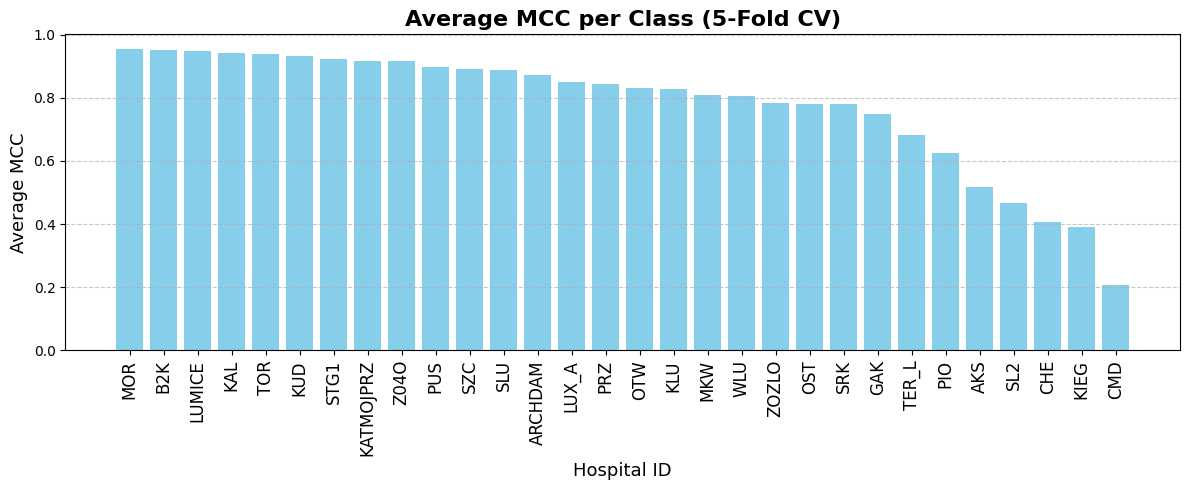

In [9]:
results_df_mean = fold_metrics_df.drop('fold', axis=1).mean(axis=0)
results_df_mean_MCC = results_df_mean[results_df_mean.index.str.startswith("MCC_")]
results_df_mean_MCC = results_df_mean_MCC.drop("MCC_Overall")
class_labels = results_df_mean_MCC.index.str.replace("MCC_", "", regex=False)

sort_idx = results_df_mean_MCC.values.argsort()[::-1]
class_labels_sorted = class_labels[sort_idx]
all_mcc = results_df_mean_MCC.values[sort_idx]

plt.figure(figsize=(12, 5))
plt.bar(class_labels_sorted, all_mcc, color='skyblue')

plt.ylabel("Average MCC", fontsize=13)
plt.xlabel("Hospital ID", fontsize=13)
plt.title("Average MCC per Class (5-Fold CV)", fontsize=16, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90, ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('results/figures/hospital_classification_avg_mcc_per_class.png', dpi=300)
plt.show()

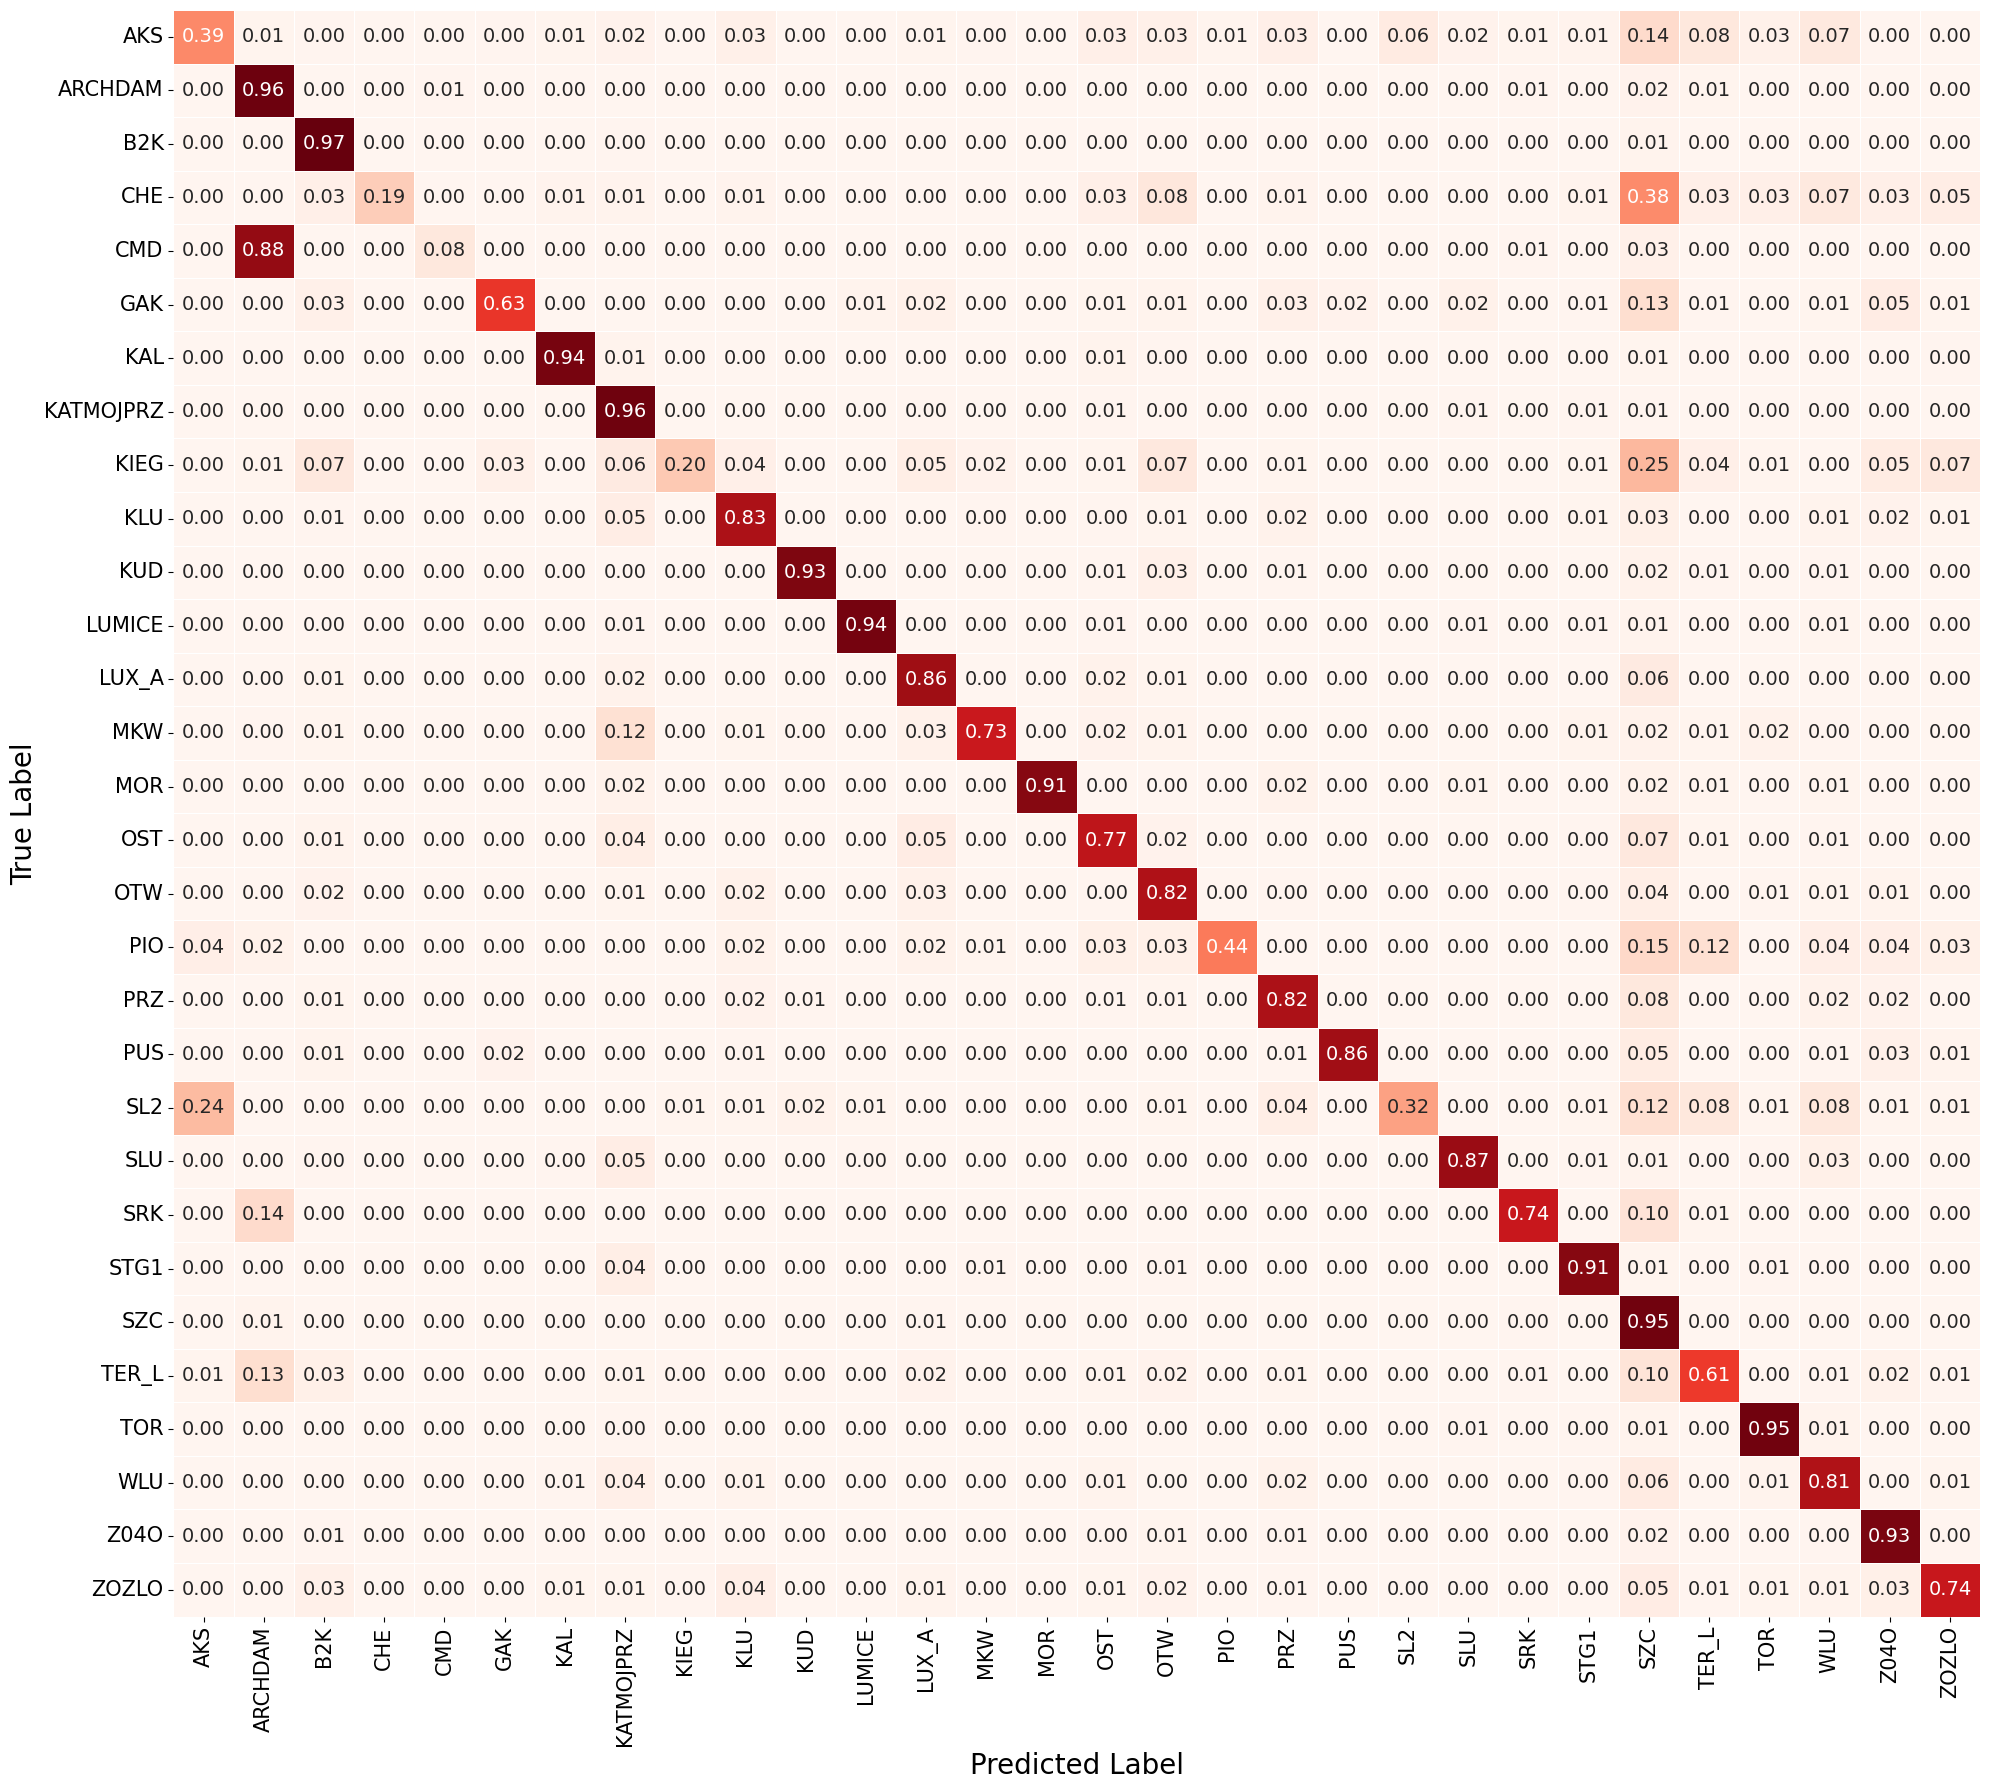

In [8]:
hospital_names = list(conf_matrices_data.values())[0]
conf_matrices = list(conf_matrices_data.values())[1:]
mean_conf_matrix = np.sum(conf_matrices, axis=0)
normalized_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(20, 18))
ax = sns.heatmap(
    normalized_conf_matrix,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.5,
    annot_kws={"size": 14},
    cbar=False
)
ax.set_xlabel("Predicted Label", fontsize=20)
ax.set_ylabel("True Label", fontsize=20)
#ax.set_title("Mean Normalized Confusion Matrix (across folds)")
plt.xticks(rotation=90)
ax.set_xticklabels(hospital_names, fontsize=15)
plt.yticks(rotation=0)
ax.set_yticklabels(hospital_names, fontsize=15)
plt.tight_layout()
plt.savefig('results/figures/hospital_classification_avg_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()